## 1. Configuracion del ambiente y descarga de archivos de datos provenientes de Amazon S3

In [ ]:
!pip install boto3

In [ ]:
import boto3
import os
from google.colab import userdata

AWS_ACCESS_KEY_ID = userdata.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = userdata.get('AWS_SECRET_ACCESS_KEY')
AWS_DEFAULT_REGION = 'us-east-1'

s3 = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_DEFAULT_REGION
)

In [ ]:
import pandas as pd
import boto3

# --- Configuración de S3 ---
# El URI que me proporcionaste
s3_uri = "s3://s3-cyberbullying-classification-data/files/md5/c8/5e2d40bf87b27619f2a4c49fcb9cda"

# Extraemos el bucket y la clave (key) del URI
bucket_name = s3_uri.split('/')[2]
object_key = '/'.join(s3_uri.split('/')[3:])


print(f"Cargando datos desde el bucket: {bucket_name}")
print(f"Clave del objeto: {object_key}")

try:
    # Obtenemos el objeto desde S3
    s3_object = s3.get_object(Bucket=bucket_name, Key=object_key)

    # Leemos el contenido del archivo (asumiendo que es un CSV) en un DataFrame
    # Nota: Si tu archivo es .json, .txt, etc., cambia pd.read_csv por la función adecuada.
    data = pd.read_csv(s3_object['Body'])

    # Mostramos las primeras filas para confirmar que se cargó correctamente
    print("\n¡Datos cargados con éxito!")
    print(data.head())

except Exception as e:
    print(f"Error al cargar los datos: {e}")

Cargando datos desde el bucket: s3-cyberbullying-classification-data
Clave del objeto: files/md5/c8/5e2d40bf87b27619f2a4c49fcb9cda

¡Datos cargados con éxito!
                                          tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying


## 2. Análisis Exploratorio de Datos (EDA)



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns # gráficos
import matplotlib.pyplot as plt #visualizacion
from wordcloud import WordCloud
import missingno as msno # #Matriz de datos incompletos

# Pre procesamiento de texto
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
data.head(10)

tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying
5  @Raja5aab @Quickieleaks Yes, the test of god i...  not_cyberbullying
6  Itu sekolah ya bukan tempat bully! Ga jauh kay...  not_cyberbullying
7  Karma. I hope it bites Kat on the butt. She is...  not_cyberbullying
8       @stockputout everything but mostly my priest  not_cyberbullying
9  Rebecca Black Drops Out of School Due to Bully...  not_cyberbullying

In [ ]:
# checking shape of the data
print("There are", data.shape[0], 'rows and', data.shape[1], "columns.")

There are 47692 rows and 2 columns.


In [ ]:
data.info() # Data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [ ]:
data.isnull().sum() #Missing values

tweet_text            0
cyberbullying_type    0
dtype: int64

<Axes: >

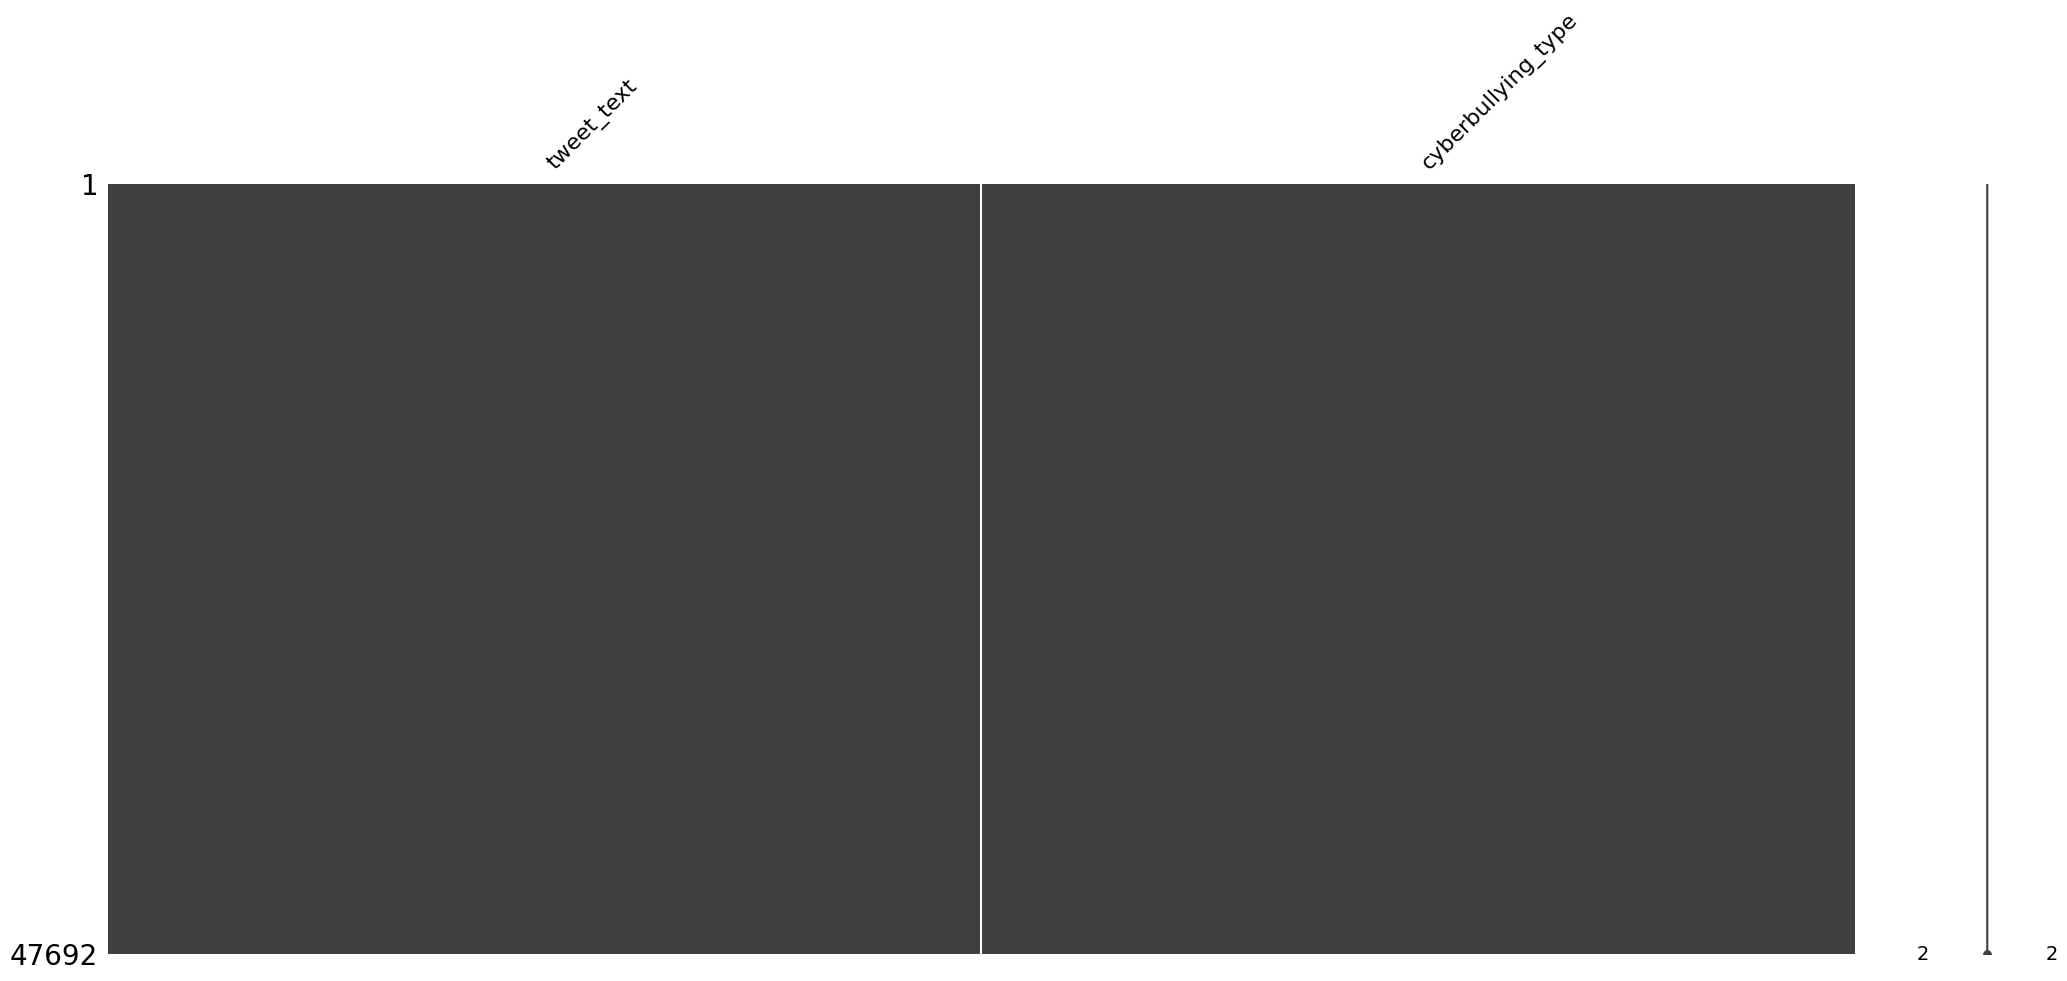

In [ ]:
msno.matrix(data)

In [ ]:
data.duplicated().sum() #Duplicates

np.int64(36)

In [ ]:
data.drop_duplicates(inplace=True) #Drops duplicates
data.reset_index(drop=True,inplace=True) #Resets index

In [ ]:
data['cyberbullying_type'].value_counts() #Tweets distribution between classes

cyberbullying_type
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64

In [ ]:
data.describe() # Important and unique values

tweet_text cyberbullying_type
count                                               47656              47656
unique                                              46017                  6
top     Leave it to GG to think women need to compete ...           religion
freq                                                    2               7997

In [ ]:
cuenta = data["tweet_text"].value_counts() #Counts unique values
print(f'Hay {len(cuenta[cuenta>=2])} tweets dobles.') # Amount of repeated tweets

Hay 1639 tweets dobles.


In [ ]:
repetidos = cuenta[cuenta>=2].index # Object with the index of tweets with 2 or more ocurrencies
duplicados = data[data["tweet_text"].isin(repetidos)]# Filters the DF with the repeated
tipos = duplicados["cyberbullying_type"].value_counts() #Filters the DF w/type of CB
print(tipos)

cyberbullying_type
other_cyberbullying    1580
not_cyberbullying      1509
gender                  176
ethnicity                 7
religion                  6
Name: count, dtype: int64


In [ ]:
grouped = duplicados.groupby('tweet_text')['cyberbullying_type'].unique() # Groups by cyberbullying type
grouped = grouped.reset_index() # Convert to DF
grouped.columns = ['tweet_text', 'cyberbullying_types'] # With column names
grouped[-10:]

tweet_text  \
1629      vomit. #stopwadhwa2015 http://t.co/78tLSv56cs   
1630          wadhwa is now blaming npr for bad health.   
1631    why is their whole menu dick related?!?!?! #MKR   
1632  yes i turned on profanity filter because i'm t...   
1633  yesssssssss https://t.co/SwnavDvwzD  @lukemcki...   
1634  you know, that's an interesting idea. Maybe I ...   
1635  your face is awful. @DarkSim7 @InvisibleJimBSH...   
1636  ~10% of the posts I've read on Facebook today ...   
1637  “@BurrawongGaian: @Le_bon_vivant_ @ConjurupFoo...   
1638  “The Fat Girl Behind the Fitness App” by @naom...   

                           cyberbullying_types  
1629  [not_cyberbullying, other_cyberbullying]  
1630  [not_cyberbullying, other_cyberbullying]  
1631  [not_cyberbullying, other_cyberbullying]  
1632  [not_cyberbullying, other_cyberbullying]  
1633  [not_cyberbullying, other_cyberbullying]  
1634  [not_cyberbullying, other_cyberbullying]  
1635  [not_cyberbullying, other_cyberbullying]  
1636  [not_cyberbullying, other_cyberbullying]  
1637  [not_cyberbullying, other_cyberbullying]  
1638               [not_cyberbullying, gender]

In [ ]:
# Drops ambiguous entries
conflict_mask = (data.groupby('tweet_text')['cyberbullying_type'].transform('nunique') > 1)
data = data[~conflict_mask].reset_index(drop=True)

In [ ]:
data.shape

(44378, 2)

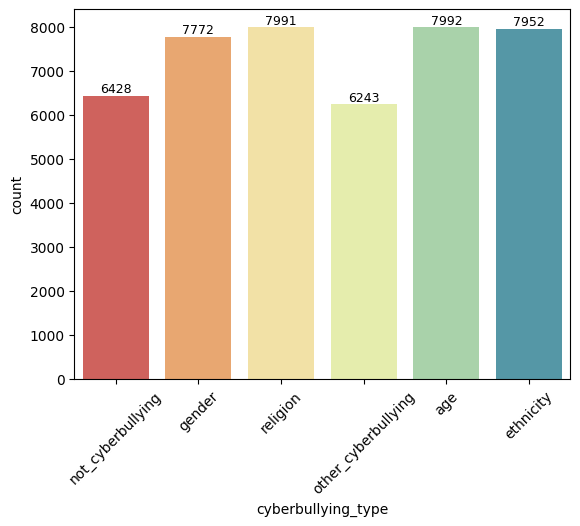

In [ ]:
#Graphic of distribution of type of CB
ax= sns.countplot(data=data,x='cyberbullying_type', hue='cyberbullying_type', palette='Spectral', legend=False)
plt.xticks(rotation=45)

for container in ax.containers: # Values of each bar
    ax.bar_label(container, label_type='edge', fontsize=9)
plt.show()

### Wordcloud - Histograma de barras


In [ ]:
# Preprocessing
lemmatizer = WordNetLemmatizer() # Creates lemmatizer

def get_wordnet_pos(tag): # Map POS tags to WordNet format
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def lemmatizer_words(text): # Creates function to tokenize and lemmatize
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens) #Part-of-speech tag
    lemmatized = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(tag)) for word, tag in tagged]
    return " ".join(lemmatized)

data['tweet_text']=data['tweet_text'].astype(str) # Turns object type to string type
data['tweet_text']=data['tweet_text'].apply(lambda text: lemmatizer_words(text)) # Lambda function to lemmatize a specific column

# Vectorizer and stop words removal
stopwords_especiales = ['rt', 'just', 'don', 'http', 'got', 'https', 'wa', 'amp', 've', 'mkr'] # List of domain-specific stop words
comb_stopwords = list(ENGLISH_STOP_WORDS.union(stopwords_especiales)) #Combine stop words

#### Genero

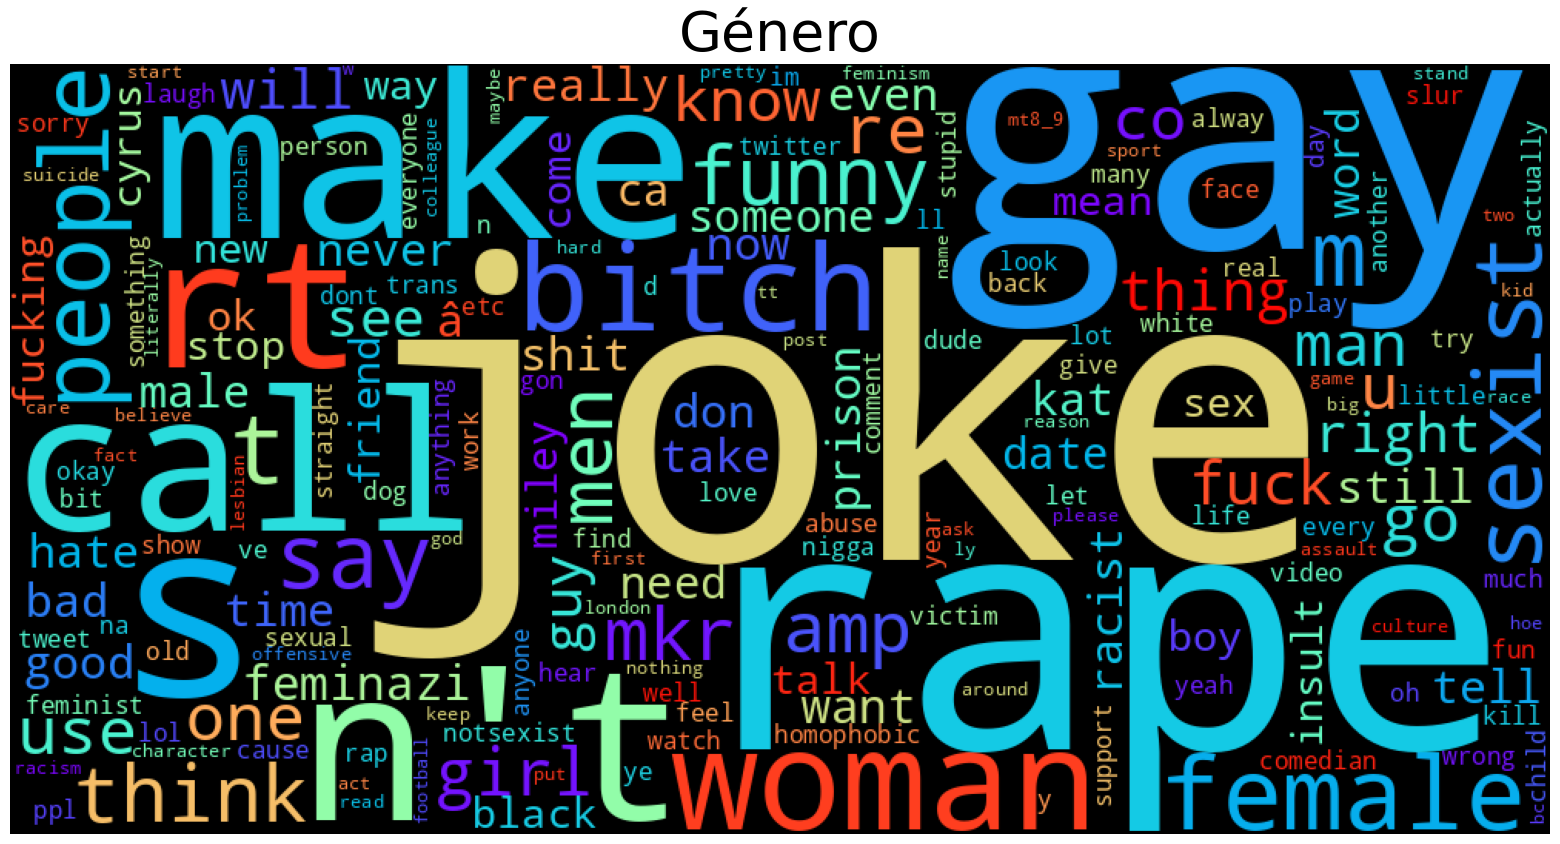

In [ ]:
# Wordcloud of gender class CB
plt.figure(figsize=(20,10))
subset1 = data[data['cyberbullying_type']=='gender']
texto_genero = subset1.tweet_text.values
texto_genero = texto_genero.tolist()
cloud_genero=WordCloud(background_color='black',colormap="rainbow",collocations=False, width=1000,height=500).generate(" ".join(texto_genero))

plt.axis('off')
plt.title("Género",fontsize=40)
plt.imshow(cloud_genero)

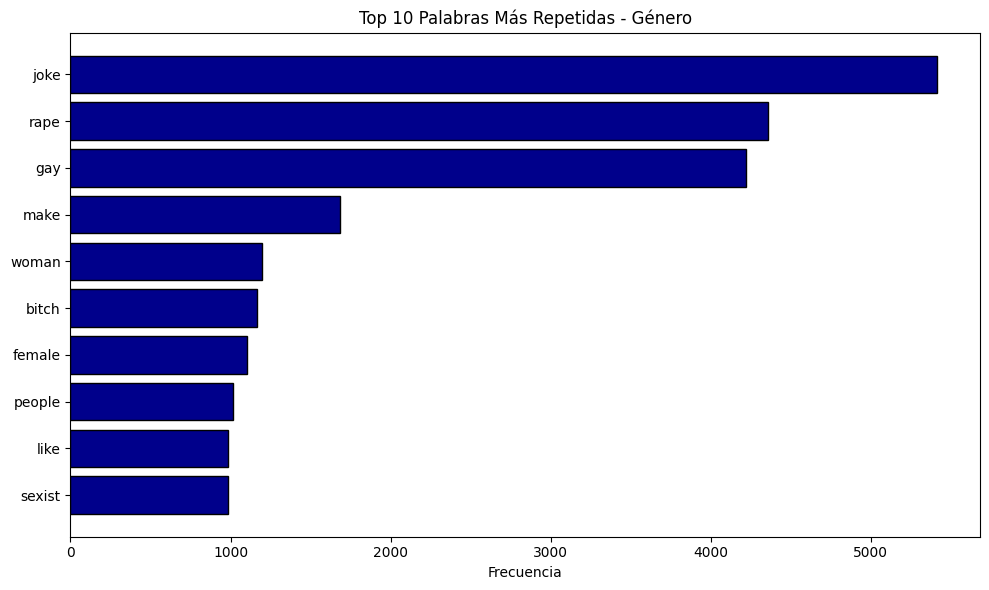

In [ ]:
# Top 10 words of gender CB
def top_words(texto, top_k=10): # Defines function to retrieve the top 10 most common words
    vectorizer = CountVectorizer(stop_words=comb_stopwords) # Vectorizer with stop words removal
    X = vectorizer.fit_transform(texto)
    word_counts = X.toarray().sum(axis=0) # Word counts
    vocab = vectorizer.get_feature_names_out() # Gets the vocabulary
    word_freq = pd.DataFrame({'word': vocab, 'count': word_counts}) # Map words to their counts
    top_words = word_freq.sort_values(by='count', ascending=False).head(top_k) # Gets top k words

    return top_words

top_10_genero = top_words(texto_genero, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_genero['word'][::-1], top_10_genero['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - Género')
plt.tight_layout()
plt.show()

#### Edad

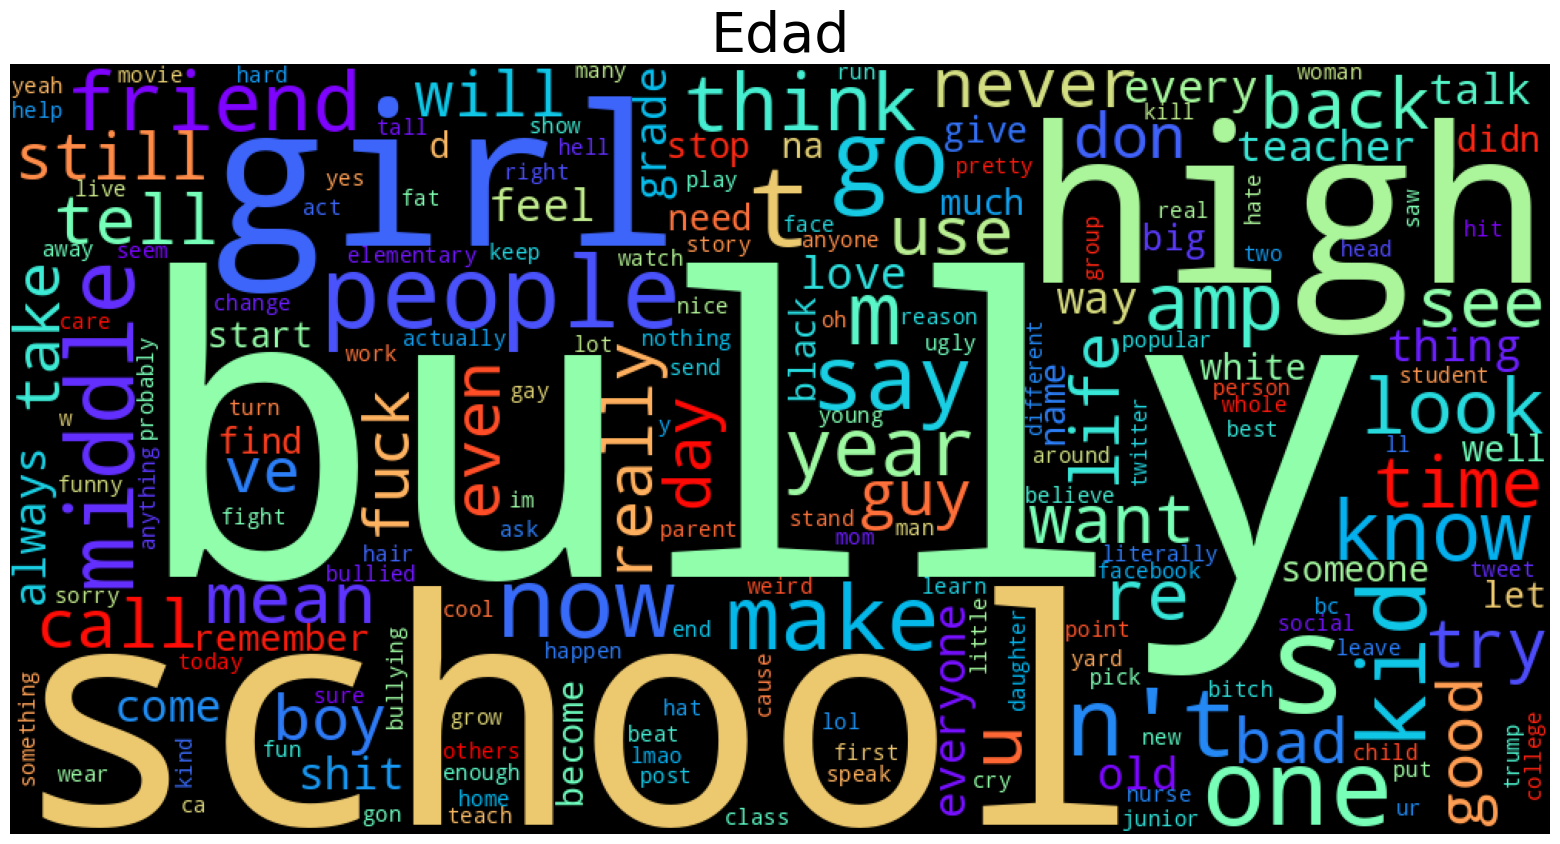

In [ ]:
# Wordcloud of age class CB
plt.figure(figsize=(20,10))
subset2 = data[data['cyberbullying_type']=='age']
texto_edad = subset2.tweet_text.values
texto_edad = texto_edad.tolist()
cloud_edad=WordCloud(background_color='black',colormap="rainbow",collocations=False, width=1000,height=500).generate(" ".join(texto_edad))

plt.axis('off')
plt.title("Edad",fontsize=40)
plt.imshow(cloud_edad)

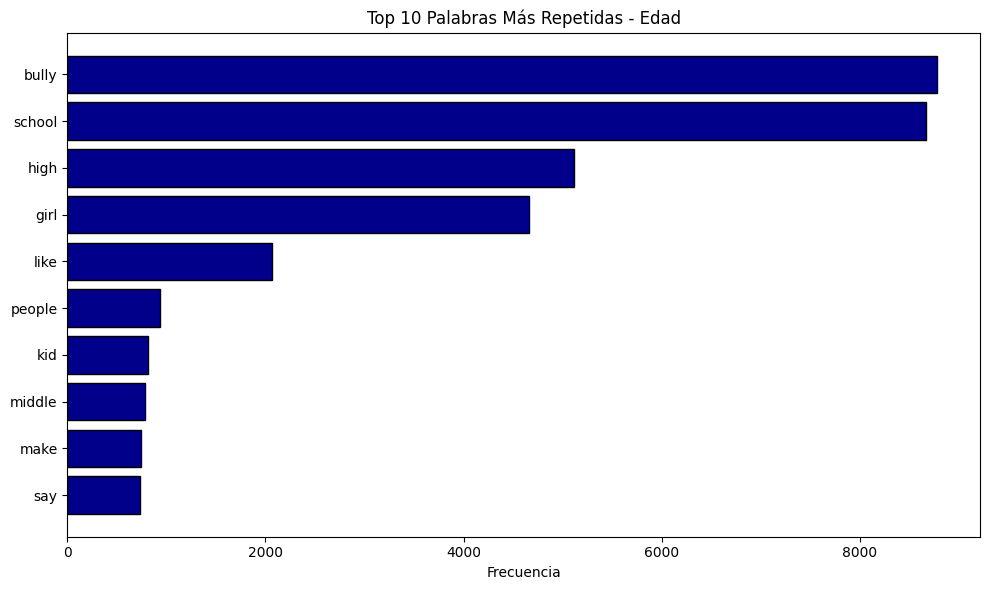

In [ ]:
# Top 10 words of age CB
top_10_edad = top_words(texto_edad, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_edad['word'][::-1], top_10_edad['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - Edad')
plt.tight_layout()
plt.show()

#### Religión

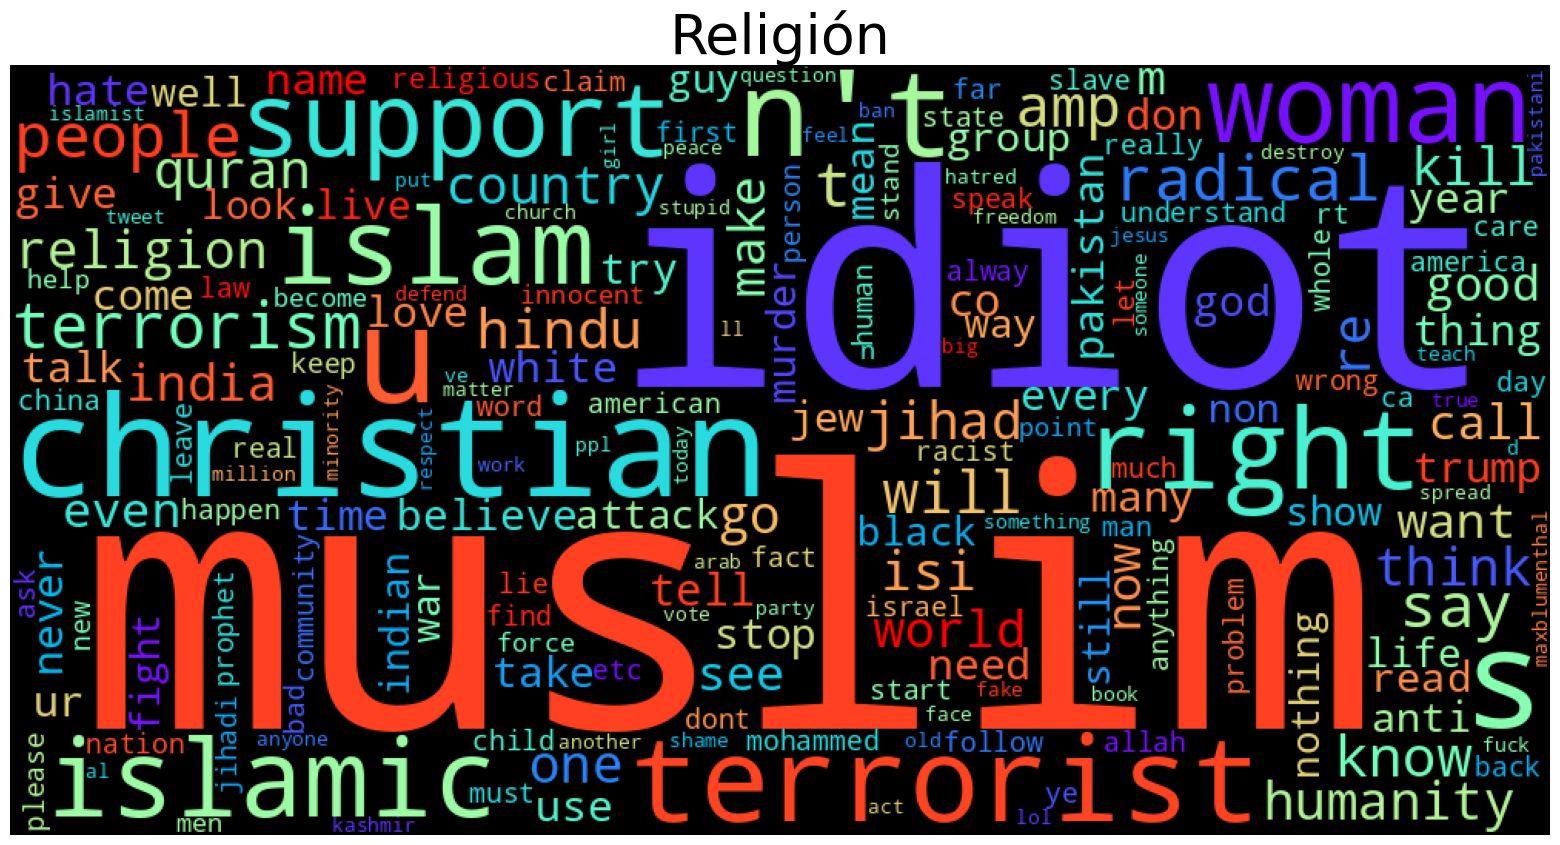

In [ ]:
# Wordcloud of religion class CB
plt.figure(figsize=(20,10))
subset3 = data[data['cyberbullying_type']=='religion']
texto_reli = subset3.tweet_text.values
texto_reli = texto_reli.tolist()
cloud_reli=WordCloud(background_color='black',colormap="rainbow",collocations=False, width=1000,height=500).generate(" ".join(texto_reli))

plt.axis('off')
plt.title("Religión",fontsize=40)
plt.imshow(cloud_reli)

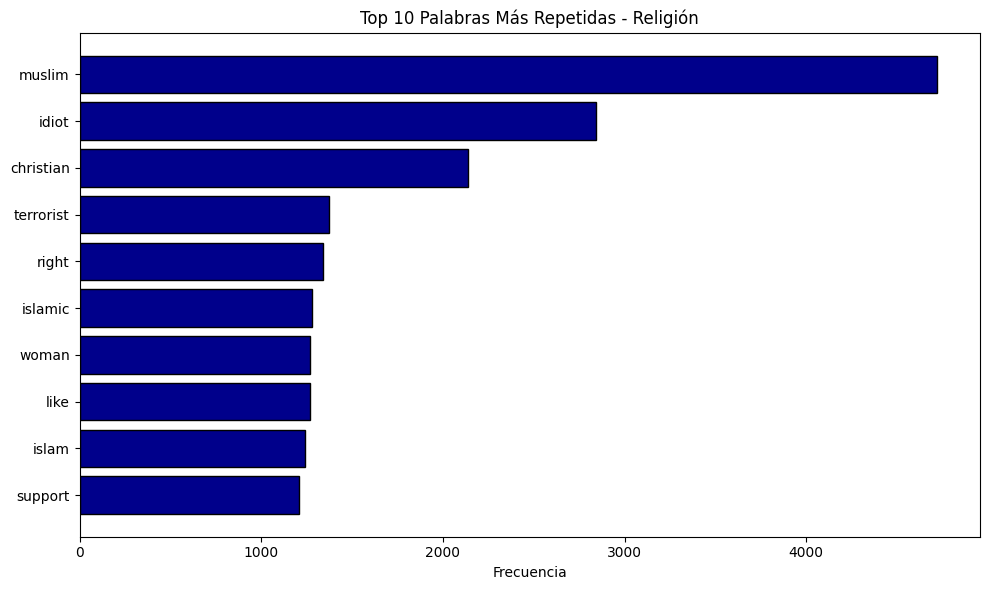

In [ ]:
# Top 10 words of religion CB
top_10_reli = top_words(texto_reli, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_reli['word'][::-1], top_10_reli['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - Religión')
plt.tight_layout()
plt.show()

#### Raza

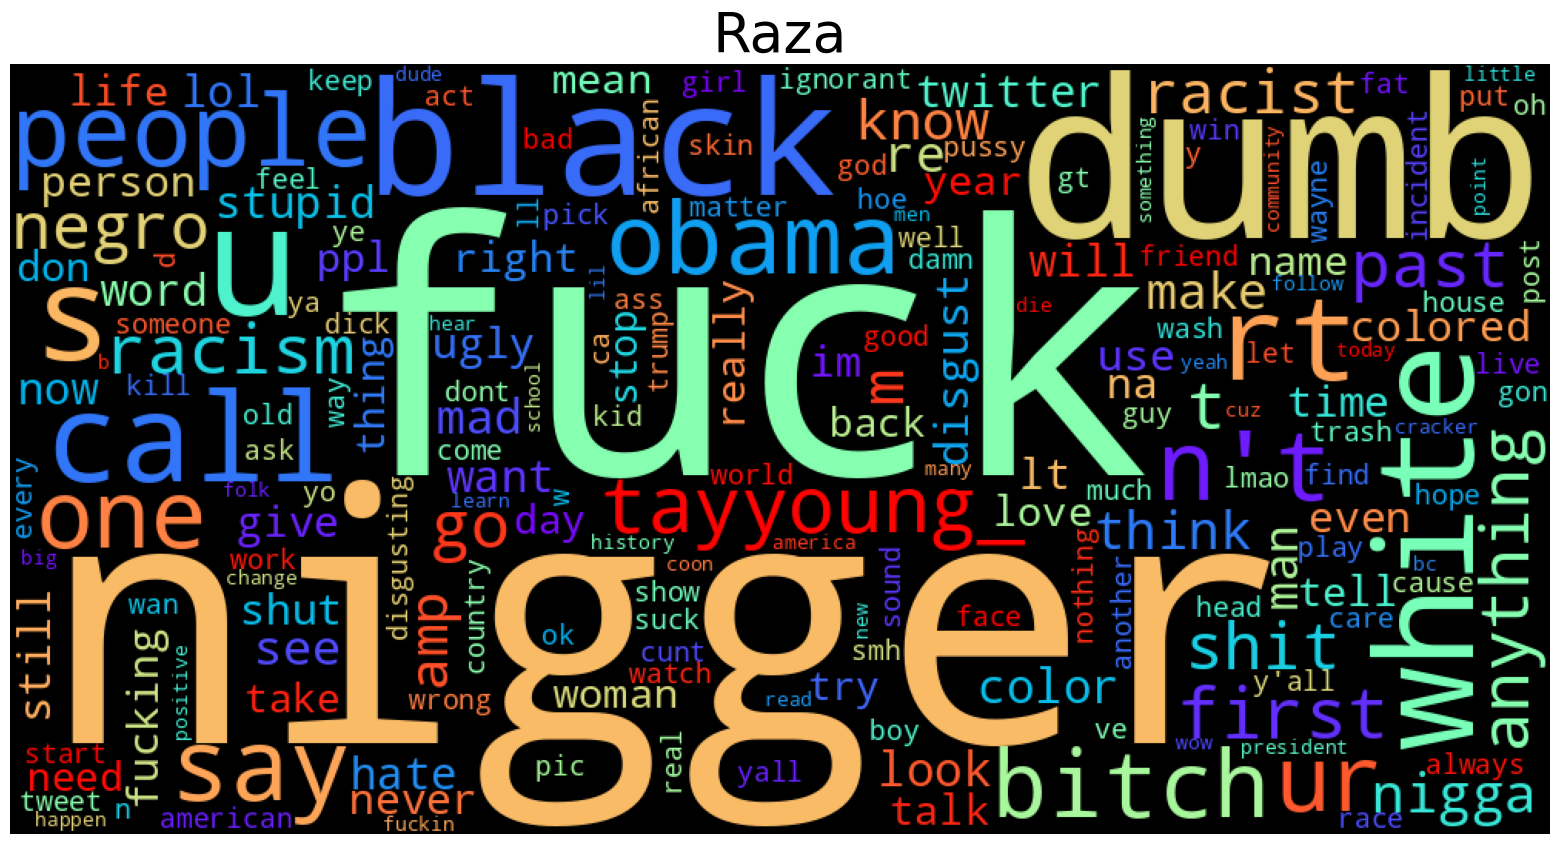

In [ ]:
# Wordcloud of ethnicity class CB
plt.figure(figsize=(20,10))
subset4 = data[data['cyberbullying_type']=='ethnicity']
texto_raza = subset4.tweet_text.values
texto_raza = texto_raza.tolist()
cloud_raza = WordCloud(background_color='black',colormap="rainbow",collocations=False, width=1000,height=500).generate(" ".join(texto_raza))

plt.axis('off')
plt.title("Raza",fontsize=40)
plt.imshow(cloud_raza)

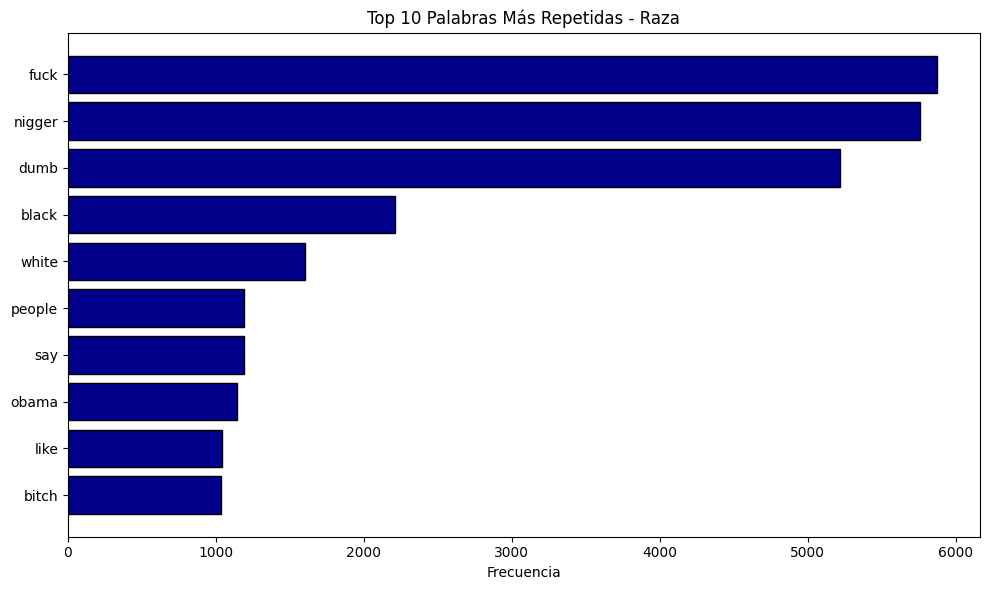

In [ ]:
# Top 10 words of ethnicity CB
top_10_raza = top_words(texto_raza, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_raza['word'][::-1], top_10_raza['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - Raza')
plt.tight_layout()
plt.show()

#### Otro tipo de ciberacoso


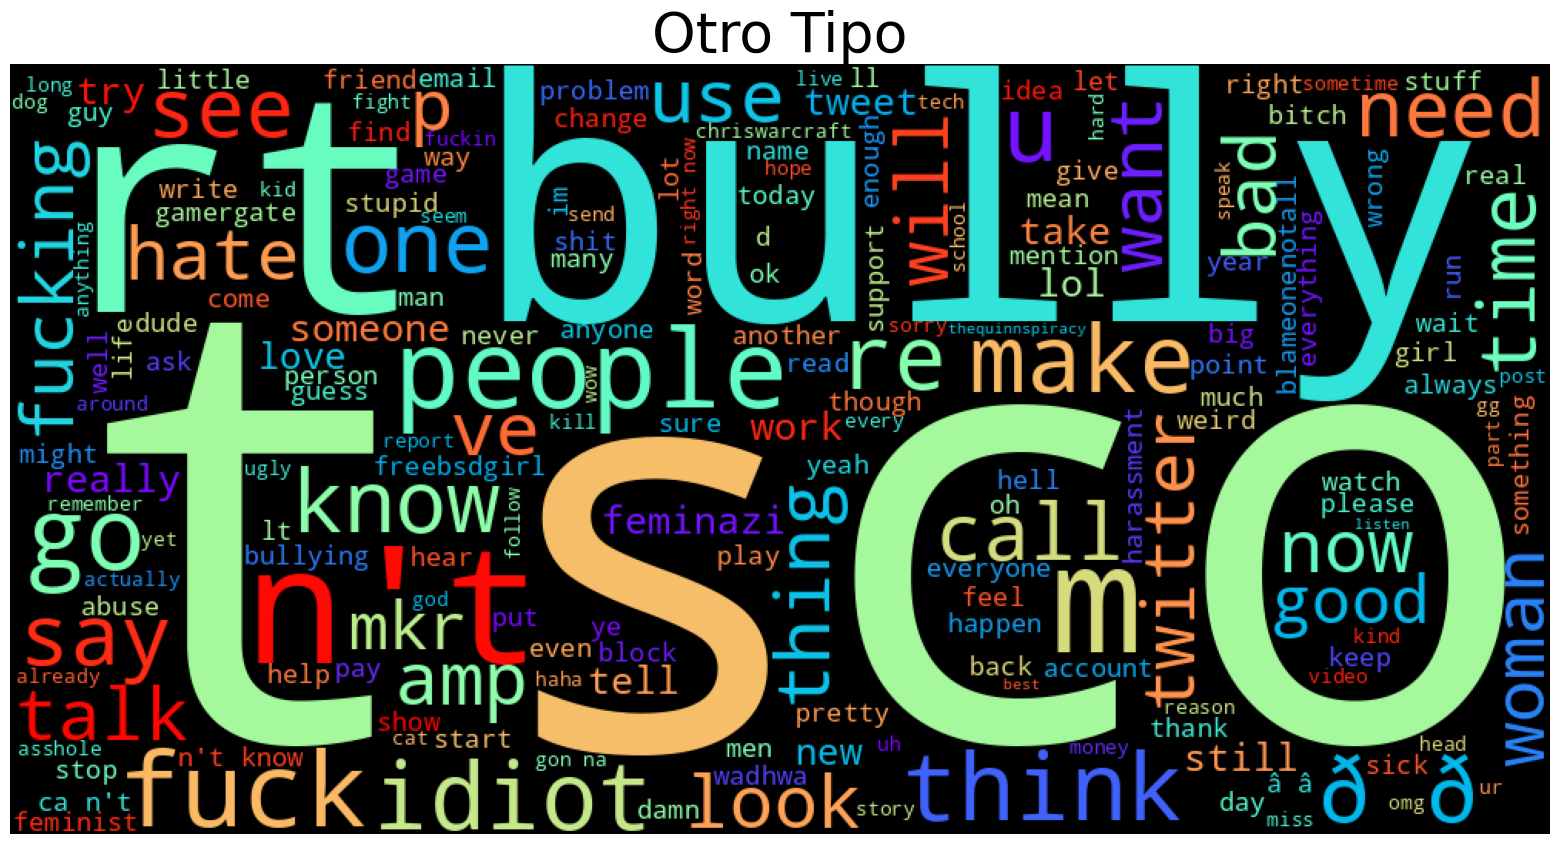

In [ ]:
# Wordcloud of other CB
plt.figure(figsize=(20,10))
subset5 = data[data['cyberbullying_type']=='other_cyberbullying']
texto_otro = subset5.tweet_text.values
texto_otro = texto_otro.tolist()
cloud_otro =WordCloud(background_color='black',colormap="rainbow", collocations=True, width=1000,height=500).generate(" ".join(texto_otro))

plt.axis('off')
plt.title("Otro Tipo",fontsize=40)
plt.imshow(cloud_otro)

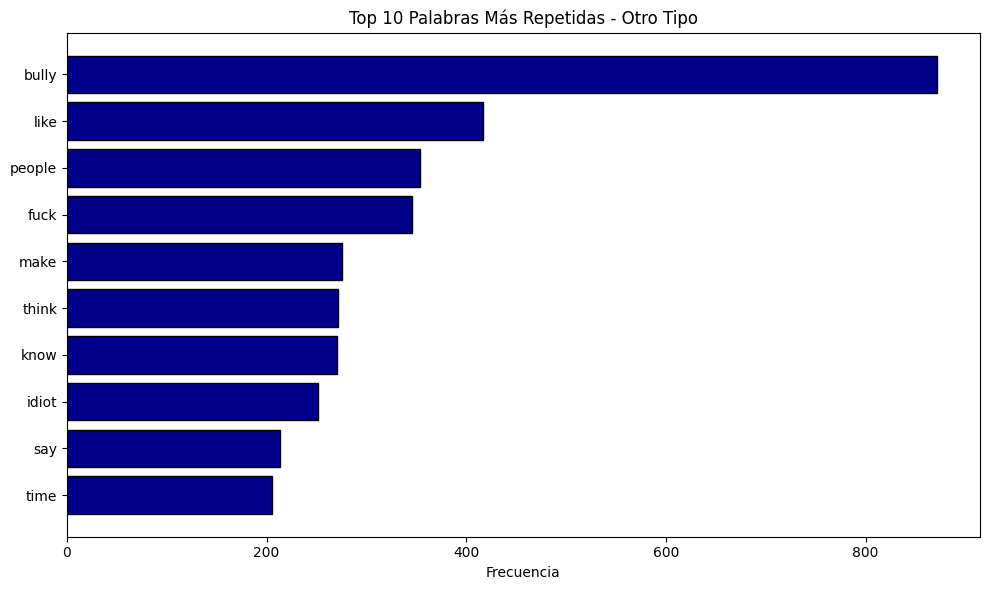

In [ ]:
# Top 10 words of other CB
top_10_otro = top_words(texto_otro, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_otro['word'][::-1], top_10_otro['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - Otro Tipo')
plt.tight_layout()
plt.show()

#### No Ciberacoso

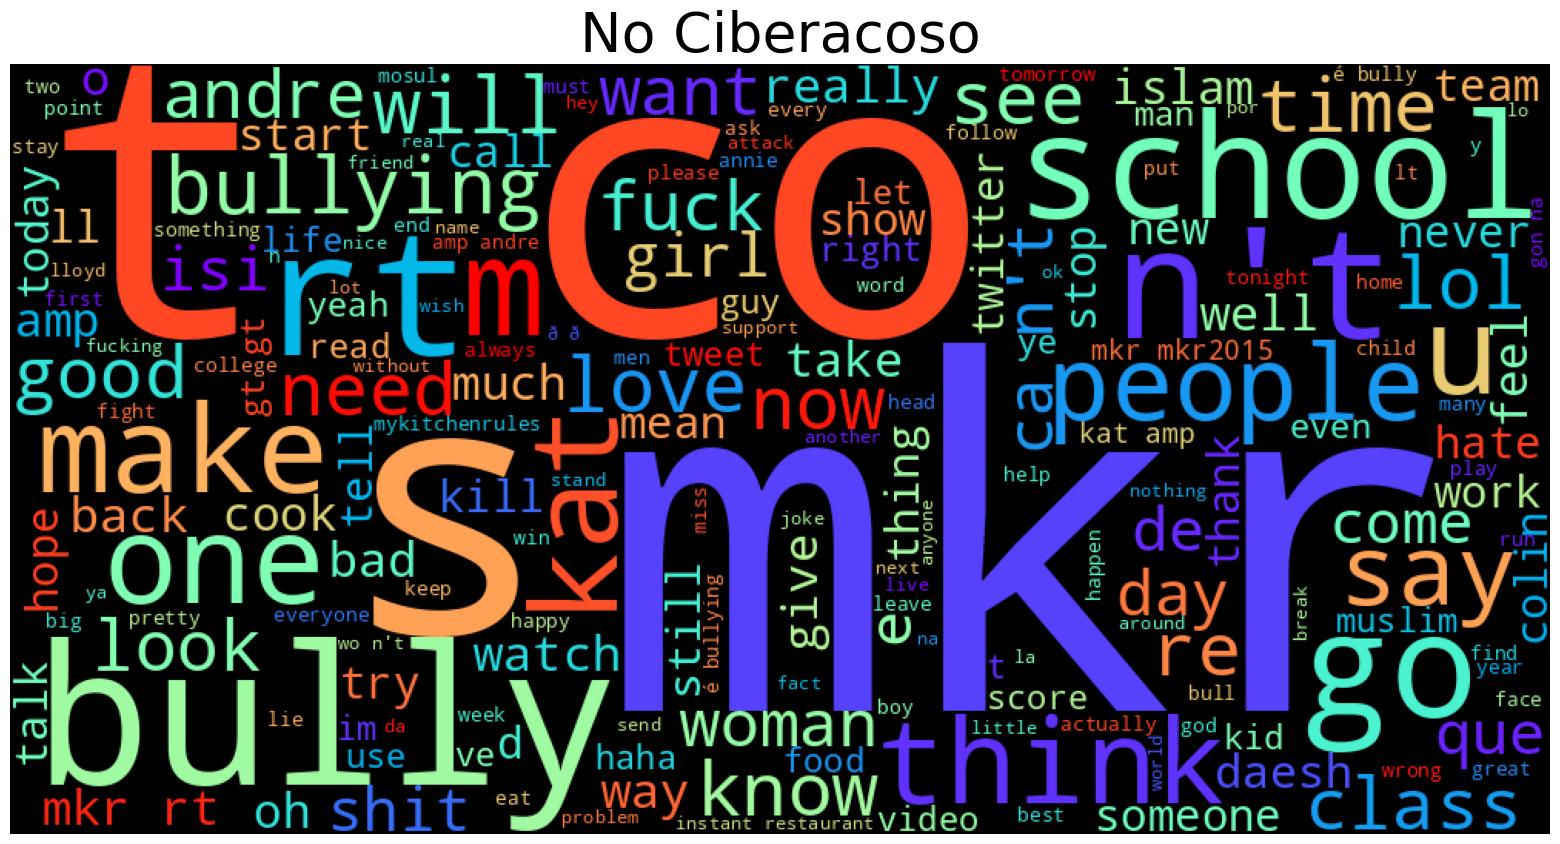

In [ ]:
# Wordcloud of other CB
plt.figure(figsize=(20,10))
subset6 = data[data['cyberbullying_type']=='not_cyberbullying']
texto_no = subset6.tweet_text.values
texto_no = texto_no.tolist()
cloud_no =WordCloud(background_color='black',colormap="rainbow", collocations=True, width=1000,height=500).generate(" ".join(texto_no))

plt.axis('off')
plt.title("No Ciberacoso",fontsize=40)
plt.imshow(cloud_no)

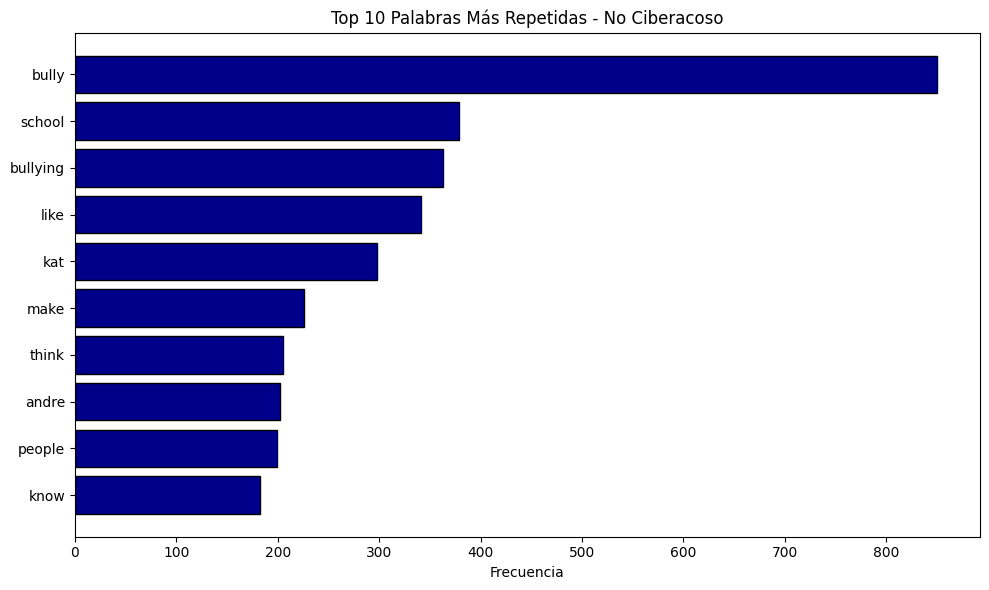

In [ ]:
# Top 10 words of other CB
top_10_no = top_words(texto_no, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_no['word'][::-1], top_10_no['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - No Ciberacoso')
plt.tight_layout()
plt.show()

## 3. Preprocesamiento y Extracción de Características

El preprocesamiento y la extracción de características son el corazón de cualquier proyecto de PLN. Es aquí donde transformamos el texto crudo en información estructurada y numérica que un modelo puede entender.

Nuestro objetivo es convertir cada mensaje de texto en un vector numérico. La técnica estándar y más efectiva para comenzar es TF-IDF (Term Frequency-Inverse Document Frequency).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Paso 1: Definir `X` (features) y `y` (target)

In [ ]:
X = data['tweet_text']  # La columna que contiene los mensajes de texto
y = data['cyberbullying_type'] # La columna con las etiquetas de clasificación

print("Variables X (texto) y y (etiquetas) definidas con éxito.")
print("Ejemplos de X:")
print(X.head())
print("\nEjemplos de y:")
print(y.head())

Variables X (texto) y y (etiquetas) definidas con éxito.
Ejemplos de X:
0    in other word # katandandre , your food be cra...
1    why be # aussietv so white ? # mkr # theblock ...
2    @ xochitlsuckkks a classy whore ? or more red ...
3    @ rudhoeenglish this be an isi account pretend...
4    @ raja5aab @ quickieleaks yes , the test of go...
Name: tweet_text, dtype: object

Ejemplos de y:
0    not_cyberbullying
1    not_cyberbullying
2    not_cyberbullying
3    not_cyberbullying
4    not_cyberbullying
Name: cyberbullying_type, dtype: object


### Paso 2: Vectorización con TF-IDF

Usaremos TfidfVectorizer de Scikit-learn. Esta herramienta es increíblemente poderosa porque hace varias cosas a la vez:

1. Tokeniza el texto (lo divide en palabras).

2. Convierte todo a minúsculas.

3. Elimina palabras comunes (stop words) que no aportan significado (como 'the', 'is', 'at').

4. Calcula los valores TF-IDF para crear los vectores numéricos.

TF-IDF le da una puntuación alta a las palabras que son frecuentes en un texto específico pero raras en todo el conjunto de datos. Esto ayuda al modelo a identificar las palabras que realmente definen una categoría.

In [ ]:
# --- Inicializar el Vectorizador TF-IDF ---
# Configuramos algunos parámetros importantes:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,       # Limita el vocabulario a las 5000 palabras más importantes.
                               # Esto ayuda a evitar el sobreajuste y reduce el ruido.

    ngram_range=(1, 2),      # Considera no solo palabras individuales (unigramas), sino también
                               # pares de palabras (bigramas). Esto captura contexto, como "no es bueno".

    stop_words='english'     # Utiliza una lista predefinida de stop words en inglés.
                               # Si tus datos están en español, usa una lista personalizada.
)


# --- Aplicar el Vectorizador a nuestros datos de texto ---
# .fit_transform() aprende el vocabulario y transforma X en una matriz numérica.
X_tfidf = tfidf_vectorizer.fit_transform(X)


# --- Verificar el resultado ---
print("\n¡Vectorización completada!")
print("La forma de nuestra nueva matriz de características (X_tfidf) es:")
print(X_tfidf.shape)


¡Vectorización completada!
La forma de nuestra nueva matriz de características (X_tfidf) es:
(44378, 5000)


## 4. Entrenamiento y Evaluación del Modelo

Vamos a dividir el proceso en cuatro pasos claros: dividir los datos, entrenar el modelo, hacer predicciones y, lo más importante, evaluar qué tan bueno es nuestro modelo.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


### Paso 1: Dividir los Datos en Entrenamiento y Prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,          # Nuestra matriz de características TF-IDF
    y,                # Nuestras etiquetas de clasificación
    test_size=0.2,    # Usaremos el 20% de los datos para la prueba
    random_state=42,  # Esto asegura que la división sea la misma cada vez que ejecutamos el código
    stratify=y        # Garantiza una división balanceada de las etiquetas
)

print("Datos divididos con éxito:")
print(f"Forma de X_train (entrenamiento): {X_train.shape}")
print(f"Forma de X_test (prueba): {X_test.shape}")

Datos divididos con éxito:
Forma de X_train (entrenamiento): (35502, 5000)
Forma de X_test (prueba): (8876, 5000)


### Paso 2: Entrenar un Modelo de Regresión Logística

In [ ]:
# Inicializamos el modelo. Aumentamos max_iter para asegurar que el modelo converja.
model = LogisticRegression(max_iter=1000, random_state=42)

# Entrenamos el modelo usando nuestros datos de entrenamiento
print("\nEntrenando el modelo de Regresión Logística...")
model.fit(X_train, y_train)
print("¡Modelo entrenado!")


Entrenando el modelo de Regresión Logística...
¡Modelo entrenado!


### Paso 3: Realizar Predicciones

In [ ]:
# El modelo predice las etiquetas para el conjunto de prueba (X_test)
y_pred = model.predict(X_test)

print("\nPredicciones realizadas en el conjunto de prueba.")


Predicciones realizadas en el conjunto de prueba.


### Paso 4: Evaluar el Rendimiento del Modelo


--- Reporte de Clasificación ---
                     precision    recall  f1-score   support

                age       0.95      0.97      0.96      1599
          ethnicity       0.98      0.96      0.97      1590
             gender       0.92      0.85      0.89      1554
  not_cyberbullying       0.67      0.63      0.65      1286
other_cyberbullying       0.67      0.76      0.71      1249
           religion       0.96      0.96      0.96      1598

           accuracy                           0.87      8876
          macro avg       0.86      0.86      0.86      8876
       weighted avg       0.87      0.87      0.87      8876


--- Matriz de Confusión ---


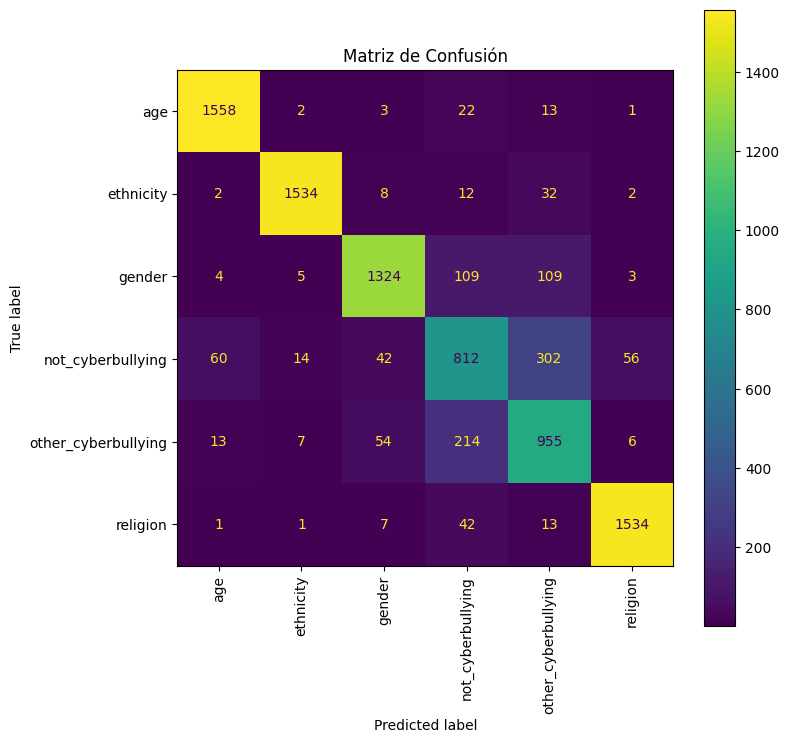

In [ ]:
# 1. Imprimir el Reporte de Clasificación
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred))


# 2. Visualizar la Matriz de Confusión
print("\n--- Matriz de Confusión ---")
# Esta función dibuja la matriz por nosotros, haciendo fácil la interpretación
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, xticks_rotation='vertical', ax=ax)
plt.title("Matriz de Confusión")
plt.show()